In [1]:
# -*- coding: utf-8 -*-
"""TimeSeries-btc - Bitcoin Price Prediction with LSTM"""

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Dropout, GRU, Conv1D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports Load/Explore/

# Initialize wandb at the top level
def init_wandb(config):
    """Initialize Weights & Biases with configuration."""
    wandb.init(
        project="btc-timeseries-forecast",  # Change this to your project name
        config=config,
        name=f"lstm_{config['lstm_units']}units_w{config['window_size']}_s{config['steps']}",
        tags=["lstm", "bitcoin", "time-series"]
    )
    return wandb.config

def load_time_series_data(coinbase_path, bitstamp_path, explore=True, plot=False):
    """Load time series data from CSV files."""
    # Read data
    print(f"Reading {coinbase_path}...")
    cb_data = pd.read_csv(coinbase_path, index_col='Timestamp')
    cb_data.index = pd.to_datetime(cb_data.index, unit='s')

    print(f"Reading {bitstamp_path}...")
    bs_data = pd.read_csv(bitstamp_path, index_col='Timestamp')
    bs_data.index = pd.to_datetime(bs_data.index, unit='s')

    data = pd.concat([cb_data, bs_data]).sort_index()
    data = data[~data.index.duplicated(keep="first")]

    if explore:
        data.info()
        print(data.head())
        print(data.describe().transpose())

        # Log data statistics to wandb
        wandb.log({
            "data_points": len(data),
            "date_range_days": (data.index[-1] - data.index[0]).days,
            "missing_values": data.isnull().sum().sum()
        })

        if plot:
            plot_col = ['Low', 'High', 'Volume_(BTC)', 'Volume_(Currency)', 'Open', 'Close']
            plot_feat = data[plot_col]
            plot_feat.index = data.index
            fig = plot_feat.plot(subplots=True, figsize=(12, 10))
            wandb.log({"data_overview": wandb.Image(plt)})
            plt.close()
    return data




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def preprocess_data(data, split=0.8, explore=False, save_path='/data/preprocess_data.npz'):
    """Preprocess time series data for training."""
    # Clean the data
    data['Volume_(BTC)'] = data['Volume_(BTC)'].fillna(0)
    data['Volume_(Currency)'] = data['Volume_(Currency)'].fillna(0)
    data['Weighted_Price'] = data['Weighted_Price'].ffill()
    data['Close'] = data['Close'].ffill()
    data['Open'] = data['Open'].ffill()
    data['High'] = data['High'].ffill()
    data['Low'] = data['Low'].ffill()

    if explore == True:
        data.info()
        print(data.head())
        print(data.describe().transpose())

    # Select features
    features = ['Weighted_Price',
                'Volume_(BTC)',
                'Volume_(Currency)',
                'Open',
                'Close',
                'High',
                'Low']

    # SAVE TIMESTAMPS BEFORE CONVERTING TO NUMPY
    timestamps = data.index.values
    data_values = data[features].values

    # Split train and val
    train_size = int(len(data_values) * split)
    train_data = data_values[:train_size]
    val_data = data_values[train_size:]

    train_timestamps = timestamps[:train_size]
    val_timestamps = timestamps[train_size:]

    # Normalize data
    mean = train_data.mean(axis=0)
    std = train_data.std(axis=0)

    train_scaled = (train_data - mean) / std
    val_scaled = (val_data - mean) / std

    scaler_info = {'mean': mean, 'std': std, 'features': features}

    # Save with timestamps
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.savez_compressed(
        save_path,
        train=train_scaled,
        val=val_scaled,
        mean=scaler_info['mean'],
        std=scaler_info['std'],
        features=np.array(scaler_info['features'], dtype=object),
        train_timestamps=train_timestamps,
        val_timestamps=val_timestamps
    )
    print(f"Preprocessed data saved to {save_path}")

    return train_scaled, val_scaled, scaler_info, train_timestamps, val_timestamps

In [3]:
# Load from saved file.
def load_preprocessed_data(load_path='data/preprocess_data.npz'):
    """Load preprocessed data from saved file."""
    if not os.path.exists(load_path):
        return None

    print(f"Loading preprocessed data from {load_path}...")
    loaded = np.load(load_path, allow_pickle=True)
    train_scaled = loaded['train']
    val_scaled = loaded['val']
    scaler_info = {
        'mean': loaded['mean'],
        'std': loaded['std'],
        'features': loaded['features'].tolist()
    }

    # Load timestamps if available
    train_timestamps = loaded.get('train_timestamps', None)
    val_timestamps = loaded.get('val_timestamps', None)

    return train_scaled, val_scaled, scaler_info, train_timestamps, val_timestamps

In [4]:
# create window function
def create_window(data, window_size=1440, steps=60, batch_size=64, target_col='Close', features=None):
    """creates a sliding window of the data.
      Args:
        window_size: Number of timesteps to use as input (1440 = 24 hours for 1-min data)
        steps: How many steps ahead to predict (60 = 1 hour)
    """
    if features is None:
      raise ValueError('Features must be provided to get target_idx')

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size + steps, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + steps))
    target_idx = features.index(target_col)
    dataset = dataset.map(lambda window: (window[:window_size], window[window_size + steps - 1, target_idx]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [5]:
# create model
def create_rnn_model(window_size, num_features, lstm_units=128, num_layers=1, dropout_rate=0.2):
    """
    Create and compile an RNN/LSTM model for time series forecasting.

    Args:
        window_size (int): Number of time steps per input sequence
        num_features (int): Number of input features
        lstm_units (int): Number of units in the LSTM layer
        num_layers (int): Number of LSTM layers
        dropout_rate (float): Dropout rate between layers

    Returns:
        model (tf.keras.Model): Compiled Keras model
    """
    model = Sequential()

    # First LSTM layer
    if num_layers > 1:
        model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window_size, num_features)))
        model.add(Dropout(dropout_rate))

        # Middle LSTM layers
        for i in range(num_layers - 2):
            model.add(LSTM(lstm_units // (2 ** (i + 1)), return_sequences=True))
            model.add(Dropout(dropout_rate))

        # Last LSTM layer
        model.add(LSTM(lstm_units // (2 ** (num_layers - 1)), return_sequences=False))
        model.add(Dropout(dropout_rate))
    else:
        # Single LSTM layer
        model.add(LSTM(lstm_units, input_shape=(window_size, num_features)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [6]:
# invert Scaling
def invert_scaling(pred_scaled, scaler_info, feature_name='Close'):
    """
    Convert scaled predictions back to real values.

    pred_scaled : np.array of shape (num_samples, ) or (num_samples, 1)
    scaler_info : dict with 'mean', 'std', 'features'
    feature_name: name of the column you want to invert
    """
    # find index of the feature
    idx = scaler_info['features'].index(feature_name)

    mean = scaler_info['mean'][idx]
    std = scaler_info['std'][idx]

    # invert
    pred_real = (pred_scaled * std) + mean
    return pred_real

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


data_points,▁
date_range_days,▁
missing_values,▁
model_parameters,▁
data_points,4364593
date_range_days,3034
missing_values,7687120
model_parameters,69761


Loading data...
Reading /content/drive/MyDrive/timeseries/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv (1).zip...
Reading /content/drive/MyDrive/timeseries/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv (1).zip...
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4364593 entries, 2011-12-31 07:52:00 to 2020-04-22 00:00:00
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
dtypes: float64(7)
memory usage: 266.4 MB
                     Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
Timestamp                                                                       
2011-12-31 07:52:00  4.39  4.39  4.39   4.39      0.455581                2.0   
2011-12-31 07:53:00   NaN   NaN   NaN    NaN           N

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,761 (272.50 KB)

 Trainable params: 69,761 (272.50 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/15
    103/Unknown 480s 5s/step - loss: 0.4150 - mae: 0.3961

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.01008, saving model to /content/drive/MyDrive/timeseries/best_model.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - loss: 0.4122 - mae: 0.3940 - val_loss: 0.0101 - val_mae: 0.0844
Epoch 2/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0692 - mae: 0.1693
Epoch 2: val_loss did not improve from 0.01008
103/103 ━━━━━━━━━━━━━━━━━━━━ 616s 6s/step - loss: 0.0688 - mae: 0.1686 - val_loss: 0.0126 - val_mae: 0.0987
Epoch 3/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0372 - mae: 0.1243
Epoch 3: val_loss improved from 0.01008 to 0.00340, saving model to /content/drive/MyDrive/timeseries/best_model.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 599s 6s/step - loss: 0.0369 - mae: 0.1237 - val_loss: 0.0034 - val_mae: 0.0476
Epoch 4/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.0356 - mae: 0.1239
Epoch 4: val_loss improved from 0.00340 to 0.00140, saving model to /content/drive/MyDrive/timeseries/best_model.keras
103/103 ━━━━━━━━━━━━━━━━━━━━ 619s 6

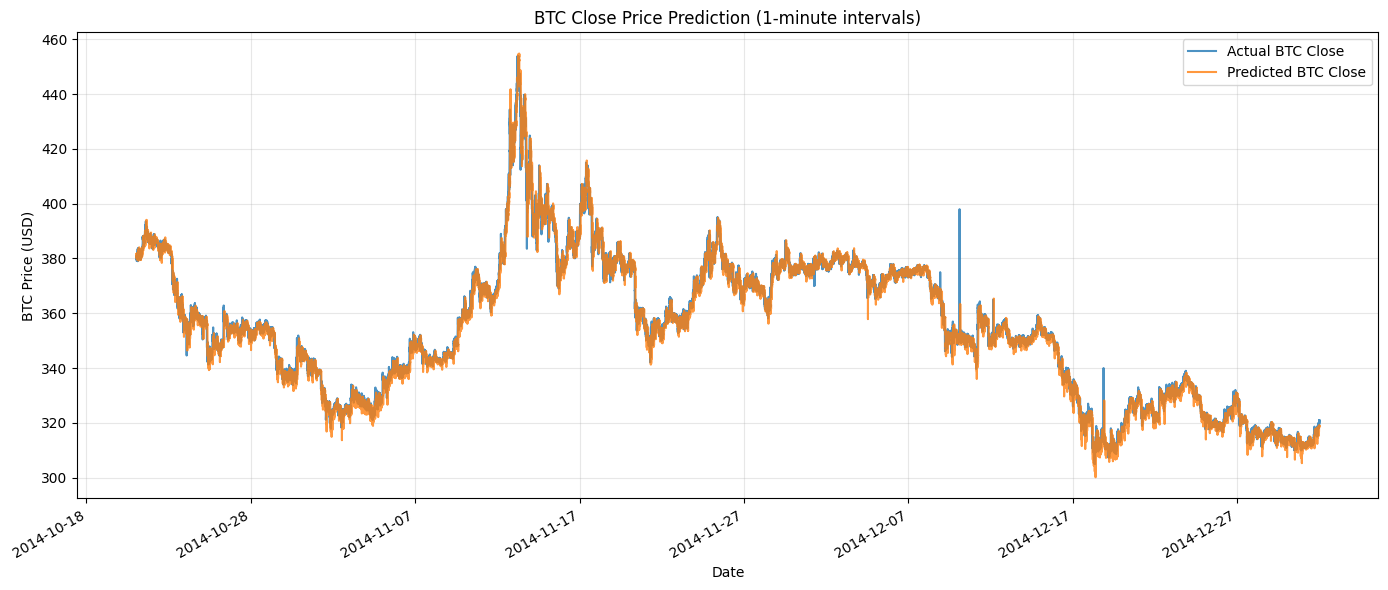


Model saved
Training history plot saved


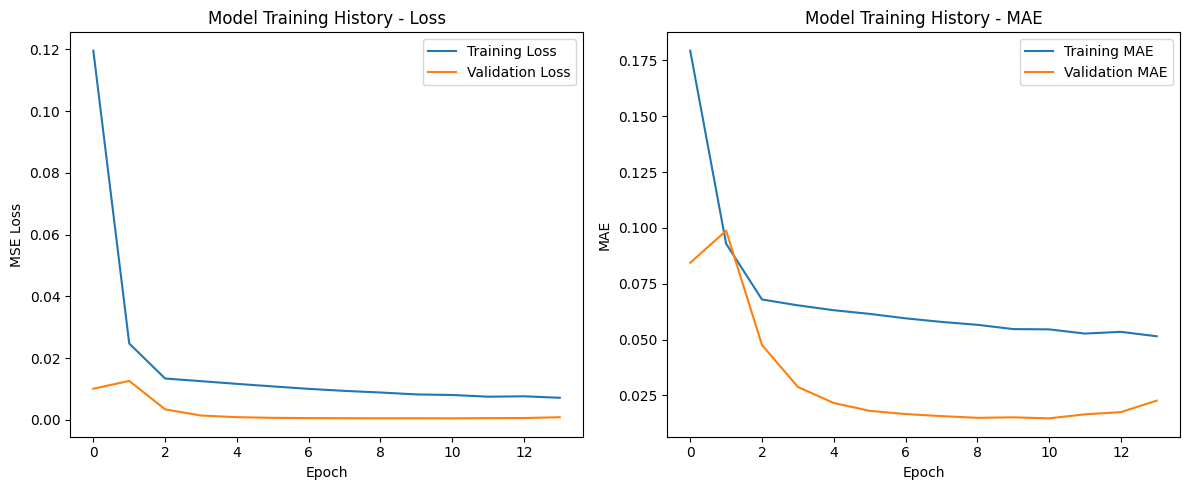

data_points,▁
date_range_days,▁
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,▇█▃▂▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,▇█▄▂▂▁▁▁▁▁▁▁▁▂
final_train_loss,▁
final_val_loss,▁
+3,...


In [10]:
# Main
def main():
    """Main function to orchestrate the workflow."""
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Configuration
    config = {
        'coinbase_path': '/content/drive/MyDrive/timeseries/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv (1).zip',
        'bitstamp_path': '/content/drive/MyDrive/timeseries/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv (1).zip',
        'preprocess_path': '/content/drive/MyDrive/timeseries/data/preprocess_data.npz',
        'window_size': 1440,
        'steps': 60,
        'batch_size': 4092,
        'lstm_units': 128,
        'num_layers': 1,
        'dropout_rate': 0.02,
        'epochs': 15,
        'learning_rate': 0.001,
        'force_preprocess': True,  # Set to True ONCE to regenerate with timestamps, then False
        'use_single_year': True,
        'year_to_use': 2014
    }

    # Initialize wandb
    wandb_config = init_wandb(config)

    # Load preprocessed data if available
    preprocessed = load_preprocessed_data(config['preprocess_path']) if not config['force_preprocess'] else None

    if preprocessed is not None and len(preprocessed) == 5:
        train_scaled, val_scaled, scaler_info, train_timestamps, val_timestamps = preprocessed
        print("Using cached preprocessed data with timestamps")
    else:
        # Load and preprocess data
        print("Loading data...")
        data = load_time_series_data(config['coinbase_path'], config['bitstamp_path'],
                                     explore=True, plot=False)

        # Filter single year if desired
        if config['use_single_year']:
            data = data[data.index.year == config['year_to_use']]
            print(f"📉 Using only data from year: {config['year_to_use']}")
            print(f"Filtered dataset size: {len(data)} rows")

        print("\nPreprocessing data...")
        train_scaled, val_scaled, scaler_info, train_timestamps, val_timestamps = preprocess_data(
            data, split=0.8, explore=True, save_path=config['preprocess_path']
        )

    # Create windowed datasets
    print("\nCreating windowed datasets...")
    train_dataset = create_window(train_scaled, config['window_size'], config['steps'],
                                  config['batch_size'], target_col='Close',
                                  features=scaler_info['features'])
    val_dataset = create_window(val_scaled, config['window_size'], config['steps'],
                                config['batch_size'], target_col='Close',
                                features=scaler_info['features'])

    # Create model
    print("\nCreating model...")
    num_features = len(scaler_info['features'])
    model = create_rnn_model(
        config['window_size'],
        num_features,
        config['lstm_units'],
        config['num_layers'],
        config['dropout_rate']
    )
    model.summary()

    # Log model architecture to wandb
    wandb.log({"model_parameters": model.count_params()})

    # Callbacks
    callbacks = [
        WandbMetricsLogger(log_freq='epoch'),
        WandbModelCheckpoint(
            filepath='/content/drive/MyDrive/timeseries/best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Train model
    print("\nTraining model...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=config['epochs'],
        callbacks=callbacks,
        verbose=1
    )

    # ------------------- PREDICT & PLOT -------------------
    print("\nPredicting on validation dataset...")

    # Get model predictions (scaled)
    pred_scaled = model.predict(val_dataset)

    # Extract actual targets (scaled)
    actual_scaled = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

    # Convert scaled values back to real BTC prices
    pred_real = invert_scaling(pred_scaled, scaler_info, feature_name='Close')
    actual_real = invert_scaling(actual_scaled, scaler_info, feature_name='Close')

    # Get corresponding timestamps
    window_size = config['window_size']
    steps = config['steps']
    num_predictions = len(actual_real)
    start_idx = window_size + steps - 1
    plot_timestamps = val_timestamps[start_idx:start_idx + num_predictions]

    # Debug information
    print(f"\n📊 Prediction Statistics:")
    print(f"Number of predictions: {num_predictions}")
    print(f"First timestamp: {pd.Timestamp(plot_timestamps[0])}")
    print(f"Last timestamp: {pd.Timestamp(plot_timestamps[-1])}")
    print(f"Time span: {pd.Timestamp(plot_timestamps[-1]) - pd.Timestamp(plot_timestamps[0])}")

    # Plot predictions vs actual WITH TIMESTAMPS
    plt.figure(figsize=(14, 6))
    plt.plot(plot_timestamps, actual_real, label='Actual BTC Close', alpha=0.8, linewidth=1.5)
    plt.plot(plot_timestamps, pred_real, label='Predicted BTC Close', alpha=0.8, linewidth=1.5)

    # Format x-axis for better date display
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Show every 10 days
    plt.gcf().autofmt_xdate()  # Rotate dates

    plt.xlabel('Date')
    plt.ylabel('BTC Price (USD)')
    plt.title('BTC Close Price Prediction (1-minute intervals)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/timeseries/prediction_vs_actual.png', dpi=150)
    print("Prediction plot saved.")
    plt.show()

    # ------------------- SAVE MODEL -------------------
    model.save('/content/drive/MyDrive/timeseries/final_model.keras')
    print("\nModel saved")

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Model Training History - Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.title('Model Training History - MAE')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/timeseries/training_history.png')
    print("Training history plot saved")
    plt.show()

    # Log final metrics to wandb
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    wandb.log({
        "final_train_loss": final_train_loss,
        "final_val_loss": final_val_loss,
        "overfitting_ratio": final_val_loss / final_train_loss
    })

    # Finish wandb run
    wandb.finish()


if __name__ == "__main__":
    main()